In [1]:
# Import the dependent python libraries

In [1]:
import numpy as np
import os
import sys
import tarfile
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import string
import h5py
from collections import Counter
from scipy.misc import imresize
from scipy.ndimage.interpolation import rotate
import matplotlib
pixel_depth = 255.0  # Number of levels per pixel.
screen_width = 800
screen_height = 600
import matplotlib.pyplot as plt
%matplotlib inline

1


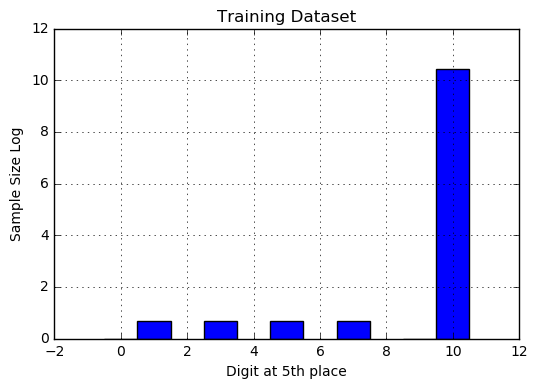

In [4]:
## Load the digitstruct.mat of the entire dataset

with open('svhn.pickle', 'rb') as f:
        dataset = pickle.load(f)

# Sample size plot in log space for better visualization
c = Counter([x[4] for x in dataset['train']['labels']])
print c[0]
l = plt.bar(c.keys(), np.log(c.values()), 1, color="blue", align = 'center')
plt.xlabel('Digit at 5th place')
plt.ylabel('Sample Size Log')
plt.grid(True)
plt.title('Training Dataset')
plt.show()


In [4]:
# As we see 5th place contains mostly space, 
# it would make 5th classifier to overfit to spaces. So I choose to ignore the last digit.

(33402, 6)


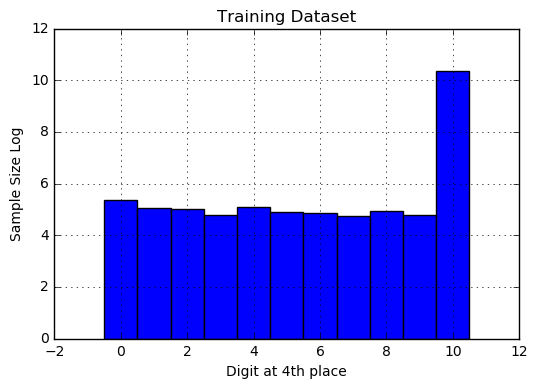

In [6]:
# Sample size plot in log space for better visualization
print dataset['train']['labels'].shape
c = Counter([x[3] for x in dataset['train']['labels']])
l = plt.bar(c.keys(), np.log(c.values()), 1, color="blue", align = 'center')
plt.xlabel('Digit at 4th place')
plt.ylabel('Sample Size Log')
plt.grid(True)
plt.title('Training Dataset')
plt.show()

653


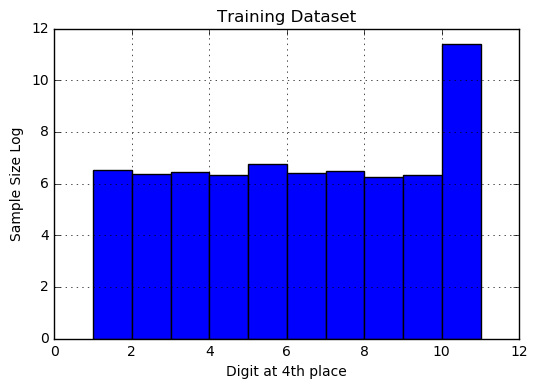

In [6]:
c = Counter([x[3] for x in dataset['extra']['labels']])
print c[7]
l = plt.bar(c.keys(), np.log(c.values()), 1, color="blue")
plt.xlabel('Digit at 4th place')
plt.ylabel('Sample Size Log')
plt.grid(True)
plt.title('Training Dataset')
plt.show()

In [7]:
# There is still lot of imbalance in data at 4th place. So I choose to oversample the digits and undersample spaces
# I collect all the samples which do not have any digits 4th place onwards and sample 15000 from them and mark the samples
# which have digits at 4th place for oversampling

In [8]:
## Gather all the images with space after 3rd digit
d = []
for i, x in enumerate(dataset['extra']['labels']):
    if x[3] != 10:
        d.append(i)
print len(d)

for i in d:
    dataset['train']['labels']  = np.append(dataset['train']['labels'],  [dataset['extra']['labels'][i]],  axis = 0)
    dataset['train']['images']  = np.append(dataset['train']['images'],  [dataset['extra']['images'][i]],  axis = 0)
    dataset['train']['tops']    = np.append(dataset['train']['tops'],    [dataset['extra']['tops'][i]],    axis = 0)
    dataset['train']['heights'] = np.append(dataset['train']['heights'], [dataset['extra']['heights'][i]], axis = 0)
    dataset['train']['widths']  = np.append(dataset['train']['widths'],  [dataset['extra']['widths'][i]],  axis = 0)
    dataset['train']['lefts']   = np.append(dataset['train']['lefts'],   [dataset['extra']['lefts'][i]],   axis = 0)
## Dump adjusted training data into a new file
with open('svhn2.pickle', 'wb') as f:
        pickle.dump(dataset, f)
print 'Pickled'

6803
Pickled


In [9]:
## Simple method to get minimum offset of bounding box
def prep(arr):
    d = [x for x in arr if x != 0]
    if d == []:
        return 0
    else:
        return min(d)
try:
    with open('svhn2.pickle', 'rb') as f:
        dataset = pickle.load(f)
except Exception as e:
    print('Unable to process data from dataset.pickle', ':', e)
    raise


In [10]:
# Oversampling by picking images from extra dataset

In [11]:
## Method when no oversampling is required
def load_image(image_file, path='train/', **box):
    from scipy.misc import imshow
    image = np.average(ndimage.imread(path+image_file), axis=2)
    try:
        if box['minTop'] < 0: box['minTop'] = 0
        if box['minLeft'] < 0: box['minLeft'] = 0
        image_data = image[box['minTop']:box['maxTopHeight'], box['minLeft']:box['maxLeftWidth']]
    
        image_data = imresize(image_data, (32,32))      
        image_data = (image_data.astype(float) - pixel_depth / 2) / pixel_depth
    except Exception, e:
        
        print e.message
        print box
        imshow(image)
    return image_data
## Method to load images from extractd folder and resize them 
def load_images(dataset, struct):
    new_y = []
    images = np.array(dataset[struct]['images'])
    tops = dataset[struct]['tops']
    widths = dataset[struct]['widths']
    heights = dataset[struct]['heights']
    lefts = dataset[struct]['lefts']
    data = []
    k = 0 #
    for i in range(images.shape[0]):
        
        if (i % 5000 == 0):
            print(i, "elapsed out of ", images.shape[0], "for: ", struct)
        try:
            if struct == 'valid':
                path = 'extra/'
            else:
                path = struct + '/'
            if i >= 33402:
                path = 'extra' + '/'
            chrCount = 4
            
            topHeights = np.array([tops[i][:chrCount], heights[i][:chrCount]])
            leftWidths = np.array([lefts[i][:chrCount], widths[i][:chrCount]])
            minTop = prep(topHeights[0, :])
            minLeft = leftWidths[0, 0]
            maxTop = topHeights.sum(axis=0).max()
            maxLeft = leftWidths.sum(axis=0).max()
            leftWidths = leftWidths.sum(axis=0).tolist()
            length = leftWidths.index(np.max(leftWidths)) + 1
            if length != 4:
                avgWidth = (maxLeft - minLeft)/ length
                maxLeft = maxLeft + int((4 - length) * avgWidth)
            image = load_image(images[i], path, **{
                    "minTop": minTop,
                    "minLeft": minLeft,
                    "maxTopHeight": maxTop,
                    "maxLeftWidth": maxLeft
                    })
            data.append(image)
            k += 1
            new_y.append(dataset[struct]['labels'][i])
        except Exception, e:
            #print length, avgWidth
            print e.message
            return
    d = np.ndarray(shape = [k, 32, 32])
    i = 0
    for i, v in enumerate(data):
        d[i, :, :] = v
    return d, np.array(new_y)



In [12]:
## Prepare the training data
trX, trY = load_images(dataset, 'train')
teX, teY = load_images(dataset, 'test')
vaX, vaY = load_images(dataset, 'valid')



(0, 'elapsed out of ', 40205, 'for: ', 'train')


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(5000, 'elapsed out of ', 40205, 'for: ', 'train')
(10000, 'elapsed out of ', 40205, 'for: ', 'train')
(15000, 'elapsed out of ', 40205, 'for: ', 'train')
(20000, 'elapsed out of ', 40205, 'for: ', 'train')
(25000, 'elapsed out of ', 40205, 'for: ', 'train')
(30000, 'elapsed out of ', 40205, 'for: ', 'train')
(35000, 'elapsed out of ', 40205, 'for: ', 'train')
(40000, 'elapsed out of ', 40205, 'for: ', 'train')
(0, 'elapsed out of ', 13068, 'for: ', 'test')
(5000, 'elapsed out of ', 13068, 'for: ', 'test')
(10000, 'elapsed out of ', 13068, 'for: ', 'test')


KeyError: 'valid'

In [13]:
try:
    with open( 'tensorflow_data.pickle', 'wb') as f:
        pickle.dump({
            'train': {'data': trX, 'label': trY},
            'test': {'data': teX, 'label': teY}}, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to',  struct + '.pickle', ':', e)

In [14]:
with open( 'tensorflow_data.pickle', 'r') as f:
    dataset = pickle.load(f)
# Sample size plot in log space for better visualization


(40205, 6)
732 31958


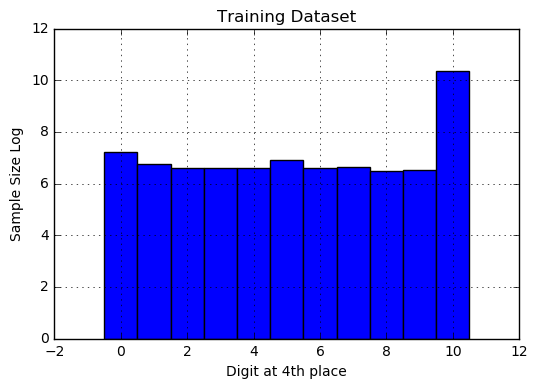

In [15]:
print dataset['train']['label'].shape
c = Counter([x[3] for x in dataset['train']['label']])
print c[6], c[10]
l = plt.bar(c.keys(), np.log(c.values()), 1, color="blue", align = 'center')
plt.xlabel('Digit at 4th place')
plt.ylabel('Sample Size Log')
plt.grid(True)
plt.title('Training Dataset')
plt.show()

In [16]:
import random

d = []
for i in range(dataset['train']['label'].shape[0]):
    if dataset['train']['label'][i][3] == 10:
        d.append(i)
## randomly sample 15000 datapoints
f_d = random.sample(d, 15000)

new_label = []
new_data = []
new_dataset = {}

for i, x in enumerate(dataset['train']['label']):
    if i in f_d:
        new_label.append(x)
        new_data.append(dataset['train']['data'][i])
    elif i not in d:
        new_label.append(x)
        new_data.append(dataset['train']['data'][i])

new_label = np.array(new_label)
new_data = np.array(new_data)

new_dataset['train'] = {}
new_dataset['train']['data'] = new_data
new_dataset['train']['label'] = new_label
new_dataset['test'] = dataset['test']
new_dataset['valid'] = {}

## Shuffle the data
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
new_dataset['train']['data'], new_dataset['train']['label'] = shuffle(new_dataset['train']['data'], new_dataset['train']['label'], random_state=0)
new_dataset['train']['data'], new_dataset['valid']['data'], new_dataset['train']['label'], new_dataset['valid']['label'] = train_test_split(new_dataset['train']['data'], new_dataset['train']['label'], test_size = 0.20, random_state = 40)


In [17]:
with open( 'tensorflow_data.pickle', 'wb') as f:
        pickle.dump(new_dataset, f, pickle.HIGHEST_PROTOCOL)
        print "Pickled"

Pickled


In [2]:
with open( 'tensorflow_data.pickle', 'r') as f:
        new_dataset = pickle.load(f)

In [6]:
## Baseline model of HOG based linear SVC
from skimage.feature import hog
from sklearn.svm import LinearSVC
import numpy as np

def accuracy(predictions, labels):
    return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

train_data   = new_dataset['train']['data'].reshape(-1, 32, 32).astype(np.float32)
test_data    = new_dataset['test']['data'].reshape(-1, 32, 32).astype(np.float32)

train_labels = new_dataset['train']['label']
test_labels  = new_dataset['test']['label']

list_hog_fd = []
for x in train_data:
    fd = hog(x, orientations = 9, pixels_per_cell = (14, 14), cells_per_block=(1, 1), visualise=False)
    list_hog_fd.append(fd)
    
hog_features = np.array(list_hog_fd, 'float64')

clf1 = LinearSVC()
clf2 = LinearSVC()
clf3 = LinearSVC()
clf4 = LinearSVC()
clf1.fit(hog_features, train_labels[:, 0])
clf2.fit(hog_features, train_labels[:, 1])
clf3.fit(hog_features, train_labels[:, 2])
clf4.fit(hog_features, train_labels[:, 3])
list_hog_fd = []
for x in test_data:
    fd = hog(x, orientations = 9, pixels_per_cell = (14, 14), cells_per_block=(1, 1), visualise=False)
    list_hog_fd.append(fd)
hog_features_test = np.array(list_hog_fd, 'float64')
label = []
label.append(clf1.predict(hog_features_test))
label.append(clf2.predict(hog_features_test))
label.append(clf3.predict(hog_features_test))
label.append(clf4.predict(hog_features_test))
predict_labels = np.array(label)
predict_labels = predict_labels.T

preds = predict_labels
tests = test_labels[:, 0:4]
print "Accuracy of the baseline model is {}".format(accuracy(preds, tests))

Accuracy of the baseline model is 70.3
